In [1]:
import os
import sys
import datetime
import string
import random
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

NAME = 'Amsgrad_fresh' # helps to differentiate between various training instances

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchtext.data import Field, BucketIterator, TabularDataset

sys.path.append(os.path.abspath(os.path.join('..')))

from models.las_model.data import SpeechDataset, AudioDataLoader
from models.las_model.listener import Listener
from models.las_model.attend_and_spell import AttendAndSpell
from models.las_model.seq2seq import Seq2Seq
# from models.las_model.utils import  train

In [2]:
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
for i in range(torch.cuda.device_count()):
    print(torch.cuda.get_device_name(i))

GeForce GTX 1080 Ti
Tesla P100-PCIE-16GB
Tesla P100-PCIE-16GB
Tesla V100-PCIE-32GB
Tesla V100-PCIE-32GB
Tesla V100-PCIE-32GB
Tesla V100-PCIE-32GB
Tesla V100-PCIE-16GB


In [3]:
data_dir = '../../../Dataset/ASR/Sinhala'

DEVICE = torch.device('cuda:6') if torch.cuda.is_available() else 'cpu'
print('DEVICE :', DEVICE)

DEVICE : cuda:6


### Preprocessing

In [4]:


# remove_chars = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', \
#                  'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', \
#                 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w',  'x', 'y', 'z', \
#                 '“', '”', '\u200b', '\u200c', '\u200d', 'µ', '\x94', '»', 'ª', '’', '‘']


# def preprocess(s):
#     s = s.replace('\n', '')  # remove '\n'
#     return s.translate(str.maketrans('', '', string.punctuation)) # remove punctuation


# # reading the main transcript
# lines = []
# with open(os.path.join(data_dir, 'utt_spk_text.tsv'), 'r', encoding='utf-8') as f:
#     lines = f.readlines()

# examples = []
# for l in lines:
#     append = True
#     id_, _, sent = l.split('\t')
#     sent = preprocess(sent)
#     for c in sent:
#         if c in remove_chars:  # removing sentences with eng_chars
#             append = False
#             break
#     if append:
#         examples.append((id_+'.flac', sent))

# data_df = pd.DataFrame(examples, columns=['path', 'sent'])
# data_df.to_csv(os.path.join(data_dir, 'data_df.csv')) # save
# print("Number of Training examples:", data_df.shape[0])
# data_df.head(5)

We have tried removing all the unnecessary characters from the dataset. The others will be replaced by unknown token, while training.

### Load data

In [5]:
from sklearn.model_selection import train_test_split

data_df = pd.read_csv(os.path.join(data_dir, 'data_df.csv'), usecols=['path', 'sent'])
train_df, val_df = train_test_split(data_df, test_size=0.01)
print("Num training example:", train_df.shape)
print("Num validation example", val_df.shape)
train_df.head()

Num training example: (148073, 2)
Num validation example (1496, 2)


,path,sent
96818,a623262a62.flac,හැටි බලන්න
130814,dfffcfa0ca.flac,ආසියා ශාන්තිකර රටවල් හයක
55958,602a828edf.flac,ඒකනම් මුලාවක් තමා
64178,6e2e65d864.flac,ඉතා හොඳීන් කැපී පෙනෙන්නේද
89586,99a1377e4c.flac,අන් අයගේ අඩුපාඩු සෙවීමය


### Vocabulary

In [6]:
chars = ['<pad>', '<unk>', '<sos>', '<eos>', 'ම', 'ෙ', ' ', 'ක', 'ැ', 'ස',\
         '්', 'බ', 'ෑ', 'ව', 'ා', 'ො', 'ර', 'ි', 'ී', 'න', 'ධ', 'ග', 'ේ',\
         'ය', 'හ', 'උ', 'ු', 'ද', 'ට', 'ල', 'අ', 'ප', 'ණ', 'ඳ', 'ත', 'ළ', 'ඩ',\
         'එ', 'ං', 'ෝ', 'ඔ', 'ඹ', 'ඇ', 'ආ', 'ඉ', 'ජ', 'ඟ', 'භ', 'ඕ', 'ශ', \
         'ූ', 'ෂ', 'ඝ', 'ෞ', 'ඒ', 'ඬ', 'ච', 'ථ', 'ඨ', 'ඊ', 'ඤ', 'ඈ', 'ඡ', \
         'ෆ', 'ඵ', 'ඛ', 'ඌ', 'ඓ', 'ෛ', 'ඪ']

char_to_token = {c:i for i,c in enumerate(chars)} 
token_to_char = {i:c for c,i in char_to_token.items()}

sos_token = char_to_token['<sos>']
eos_token = char_to_token['<eos>']
pad_token = char_to_token['<pad>']
unk_token = char_to_token['<unk>']

print("Number of characters:", len(chars))

Number of characters: 70


### Instantiate model

In [7]:
input_size = 128    # num rows in instagram
hidden_dim = 256  
num_layers = (1,3)
dropout = 0.1
layer_norm = True   
encoder = Listener(input_size, hidden_dim, num_layers, dropout=dropout, layer_norm=layer_norm)

hid_sz = 256
vocab_size = len(chars)
decoder = AttendAndSpell(hid_sz, encoder.output_size, vocab_size)

hyperparams = {'input_size':input_size, 'hidden_dim':hidden_dim, 
               'num_layers':num_layers,'dropout':dropout, 
               'layer_norm':layer_norm, 'hid_sz':hid_sz, 
               'vocab_size':vocab_size}

model = Seq2Seq(encoder, decoder, tf_ratio = 1.0, device=DEVICE).to(DEVICE)
model.train()

Seq2Seq(
  (encoder): Listener(
    (lstm_layers): LSTM(128, 256, bidirectional=True)
    (pblstm_layers): ModuleList(
      (0): piBLSTM(
        (lstm): LSTM(512, 256, batch_first=True, bidirectional=True)
        (ln): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dp): Dropout(p=0.1, inplace=False)
      )
      (1): piBLSTM(
        (lstm): LSTM(1024, 256, batch_first=True, bidirectional=True)
        (ln): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dp): Dropout(p=0.1, inplace=False)
      )
      (2): piBLSTM(
        (lstm): LSTM(1024, 256, batch_first=True, bidirectional=True)
        (ln): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dp): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (decoder): AttendAndSpell(
    (attention_layer): Attention(
      (linear1): Linear(in_features=1280, out_features=640, bias=True)
      (linear2): Linear(in_features=640, out_features=1, bias=True)
    )
    (pre_lstm_cell): LSTMCell(1094

### Training

In [8]:
# # model.load_state_dict(torch.load(os.path.join(save_dir, 'las_model_1')))
# # model.train()

# # load = False
# # if load:
# #     saved_file = 'Trained Models/Training_2019-12-25 00:09:23.921978/las_model_6'
# #     model.load_state_dict(torch.load(saved_file))
# #     start_epoch = int(saved_file[-1]) + 1
# #     time = os.listdir(tensorboard_dir)[-1]  # use the last one 

time = str(datetime.datetime.now())
save_dir = os.path.join('trained_models', f'{NAME}_{time}')
try:    
    os.mkdir(save_dir);
except FileExistsError:
    pass

# Saving hyperparmas
with open(os.path.join(save_dir, 'info.pickle'), 'wb') as f:
    pickle.dump(hyperparams, f)

In [24]:
def train(model, device, train_loader, optimizer, epoch, vocab_size, 
          print_interval, writer=None, log_interval=-1, scheduler=None, train_dataset=None):
    
    model.train()
    print(f'Training, Logging: Mean loss of previous {print_interval} batches \n')
    
    running_loss = []
    date1 = datetime.datetime.now()
    

    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        out, _ = model(data, target)
        
        loss = F.cross_entropy(out.view(-1, vocab_size), target.view(-1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss.append(loss.detach().item())    # update running loss

        # writing to console after print_interval batches
        if (batch_idx+1) % print_interval == 0:
            date2 = datetime.datetime.now()
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tMean Loss : {:.6f}\t lr {}\t time {}:'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), 
                np.mean(running_loss[-print_interval:]), 
                optimizer.state_dict()['param_groups'][0]['lr'],
                date2 - date1))
            date1 = date2

        # Writing to tensorboard
        if (batch_idx+1) % log_interval == 0:
            if writer:
                global_step = epoch * len(train_loader) + batch_idx
                writer.add_scalar('Loss', np.mean(running_loss[-log_interval:]), global_step)

        if batch_idx == len(train_loader)//2:
            # save, # check, 
            torch.save(model.state_dict(), os.path.join(save_dir, f'las_model_half_{epoch}'))
            torch.save(optimizer.state_dict(), os.path.join(save_dir, f'optim_half_{epoch}'))
            validate_personal(model, 2, train_dataset)
                
    
def decode_pred_sent(out):
    pred_sent = []
    out = out.squeeze(0)
    for t in out:
        lol = t.max(dim=0)[1].item()
        pred_sent.append(token_to_char[lol])
    return pred_sent


def decode_true_sent(y):
    sent = []
    for t in y:
        sent.append(token_to_char[t.item()])
    return sent


def plot_att(att_vects, pred_sent):       
    att_map = torch.cat(att_vects, dim=0).squeeze(2)
    
    plt.clf()
    f = plt.figure()
    ax = f.add_subplot(1, 1, 1)

    # add image
    i = ax.imshow(att_map.detach().cpu(), interpolation='nearest', cmap='Blues')

    # add colorbar
    cbaxes = f.add_axes([0.2, 0, 0.6, 0.03])
    cbar = f.colorbar(i, cax=cbaxes, orientation='horizontal')
    cbar.ax.set_xlabel('Alpha value (Probability output of the "softmax")', labelpad=2)

    # add labels
    ax.set_yticks(range(len(pred_sent)))
    ax.set_yticklabels(pred_sent)
    ax.set_ylabel('Output Sequence')
    plt.show()



def validate(model, num_sent, dataset, plot_attention=True):
    model.eval()
    for _ in range(num_sent):
        idx = random.randint(0, dataset.__len__())

        x, y = dataset.__getitem__(idx)
        
        target = y.unsqueeze(dim=0).to(DEVICE)
        data = x.permute(0, 2, 1).to(DEVICE)
        output, att_vectors = model(data, target)
        
        true_sent = decode_true_sent(y)
        pred_sent = decode_pred_sent(output)
        
        print('Tx:', data.shape[1], '->', att_vectors[0].shape)
        print("\nTrue sent : ", ''.join(true_sent))
        print("Pred sent : ", ''.join(pred_sent))
        
        if plot_attention:
            plt.imshow(x[0].log2().numpy())
            plt.show()
            plot_att(att_vectors, pred_sent)
        
    model.train()

In [10]:
# checking the width
train_dataset = SpeechDataset(train_df, data_dir, char_to_token, n_fft=1024, hop_length=256)
train_loader = AudioDataLoader(pad_token, train_dataset, batch_size=64, 
                               shuffle=True, drop_last=True, num_workers=8)

df = 2**int(model.encoder.num_layers[1])
print("Downsampling factor", df)
for i in range(5):
    idx = random.randint(0, train_dataset.__len__())
    x, y = train_dataset.__getitem__(idx)
    Tx = x.shape[2]
    print('Tx:', Tx, '->', int(Tx/df))

Downsampling factor 8
Tx: 219 -> 27
Tx: 344 -> 43
Tx: 332 -> 41
Tx: 394 -> 49
Tx: 238 -> 29


In [11]:
# optimizer = optim.SGD(model.parameters(), lr=0.2)  # lr = 0.2 used in paper
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, verbose=True, cooldown=5, min_lr=0.00001)

optimizer = optim.Adam(model.parameters(), amsgrad=True)

# optimizer = optim.Adadelta(model.parameters())
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1, )

log_interval = 20
print_interval = 50

epochs = 20
load = False

writer = SummaryWriter(save_dir)
print('save_dir', save_dir)



# load_dict = 'trained_models/Adadelta_NC_step_1_2019-12-31 04:30:30.395730'
# model.load_state_dict(torch.load(os.path.join(load_dict, 'las_model_half_0')))
# optimizer.load_state_dict(torch.load(os.path.join(load_dict, 'optim_half_0')))


for epoch in range(1, epochs): 
    train(model, DEVICE, train_loader, optimizer, epoch, vocab_size, print_interval)#, writer, 
          #log_interval, scheduler=True, train_dataset=train_dataset)
    
    #save model
    torch.save(model.state_dict(), os.path.join(save_dir, f'las_model_{epoch}'))
    torch.save(optimizer.state_dict(), os.path.join(save_dir, f'optim_{epoch}'))
    
    validate_personal(model, 2, train_dataset)
    
    # Decrease tf_ratio
#     if (epoch+1)%10 == 0:
#         model.tf_ratio = model.tf_ratio - 0.5
#         print("\nTeacher forcing ratio:", model.tf_ratio)
    
#     if scheduler:
#         validate_personal(model, 2, train_dataset)
#         for param_group in optimizer.param_groups:
#             param_group['lr'] = max(param_group['lr']*0.1, 0.001)
#         print("-"*10, "LR decreased", '-'*10)

Training, Logging: Mean loss of previous 50 batches 

Train Epoch: 1 [3136/148073 (2%)]	Mean Loss : 4.247186	 lr 0.001	 time 0:00:23.662554:
Train Epoch: 1 [6336/148073 (4%)]	Mean Loss : 4.239796	 lr 0.001	 time 0:00:23.421406:
Train Epoch: 1 [9536/148073 (6%)]	Mean Loss : 4.232976	 lr 0.001	 time 0:00:21.692694:
Train Epoch: 1 [12736/148073 (9%)]	Mean Loss : 4.228881	 lr 0.001	 time 0:00:22.864486:
Train Epoch: 1 [15936/148073 (11%)]	Mean Loss : 4.224662	 lr 0.001	 time 0:00:22.428642:
Train Epoch: 1 [19136/148073 (13%)]	Mean Loss : 4.223318	 lr 0.001	 time 0:00:22.723982:
Train Epoch: 1 [22336/148073 (15%)]	Mean Loss : 4.220707	 lr 0.001	 time 0:00:22.253101:
Train Epoch: 1 [25536/148073 (17%)]	Mean Loss : 4.221615	 lr 0.001	 time 0:00:22.426262:
Train Epoch: 1 [28736/148073 (19%)]	Mean Loss : 4.217332	 lr 0.001	 time 0:00:21.995003:
Train Epoch: 1 [31936/148073 (22%)]	Mean Loss : 4.211217	 lr 0.001	 time 0:00:22.324876:
Train Epoch: 1 [35136/148073 (24%)]	Mean Loss : 4.206993	 lr 0.

NameError: name 'save_dir' is not defined

In [ ]:
# #--------------continue training----------------------#
# for param_group in optimizer.param_groups:
#     param_group['lr'] = max(param_group['lr']*0.5, 0.0001)
#     print(param_group['lr'])

### TEST

Tx: 313 -> torch.Size([1, 39, 1])

True sent :  මෙම වැල් වර්ග එකක් වත්<eos>
Pred sent :  <pad>ව<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>ෙ<eos><eos>


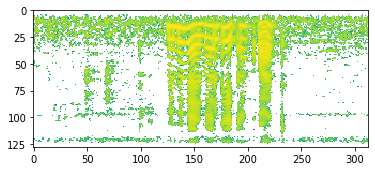

<Figure size 432x288 with 0 Axes>

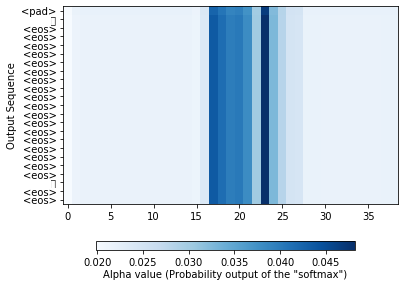

Tx: 182 -> torch.Size([1, 22, 1])

True sent :  ඒත් සන්නස්ගල කියන්නේ<eos>
Pred sent :  <pad>වව<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>ො<eos><eos><eos><eos><eos><eos>


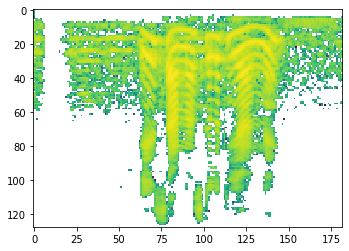

<Figure size 432x288 with 0 Axes>

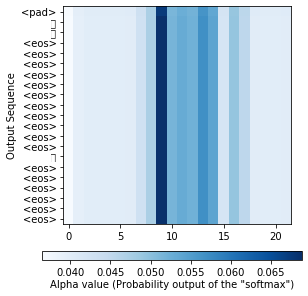

In [26]:
validate(model, 2, train_dataset)